<a href="https://colab.research.google.com/github/saadhassan99/Named-Entity-Recognition-NLP/blob/main/Entity_Recognition_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entity Recognition:

**Analysis Pipeline: the OSEMN approach:**

Following the OSEMN approach, I will take the following steps:

*   **Obtain the data:**

    The data is been provided as a txt file

*   **Scurbbing/Cleaning the data:**

    Initial data exploration and preparation for analysis

*   **Exploratory/Visualizing the Data (EDA):**

    Basic EDA to understand the data

*   **Modeling the Data:**

    Create classification models for NER
    
    I will take two approaches to model the data:

    *   **Machine Learning Approach**

        *   tree based model - RandomForest
        *   State of the art CRF model
        *   Hyperparameter tuning
    
    *   **Deep Learning Approach**

        *   Bidirectional-LSTM model

*   **Interpreting the Results**

    Analysing the performance and further steps to improve













Note: This coding is written in Jupyter Notebook hosted by Google Colab

In [ ]:
# Data analysis
import numpy as np
import pandas as pd

#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Load the Data

In [ ]:
%%time
import spacy
nlp = spacy.load("en_core_web_sm")
from tqdm import tqdm
train = []
tmp = []
#line_no = 1
sentence_no = 1
with open("/content/train.txt") as fp:
    for l in fp.readlines():
        if l == "\t\n" or len(l) == 1:
            train.extend(tmp)
            sentence_no += 1
            tmp = []
        else:
            doc = nlp(l.split("\t")[0])
            for token in doc:
                tmp.append((sentence_no, l.split("\t")[0], token.pos_, l.split()[1]))
        # line_no+=1
        # if line_no == 200:
        #     break

CPU times: user 5min 10s, sys: 281 ms, total: 5min 10s
Wall time: 5min 10s


I found that different sentences were seperated by a blank line. In some lines instead of "\t\n" as the blank Line we have only "\n".

I decided to deal with this now because it can cause significant challenges during the cleaning process. To handle this we can check if length is 1 and in that case also we add our tmp to train.

**Dataset info:**

The dataset contains the following columns:

**Index** - Index numbers for each word [Numeric type]

**word** - The words in the sentence [Character type]

**Tag** - The tags given to each word based on the IOB tagging system described above (Target variable) [Categorical type]

I also added two more columns to the dataset. 

**sentence #** - to keep track of our sentences, now that we have gotten rid of the blank lines. [Numeric type]

**POS** - Parts Of Speech tags, these are tags given to the type of words as per the Penn TreeBank Tagset [Categorical type]

In [ ]:
from pandas import DataFrame

# let convert our training data to a pandas dataframe, so we can work with it more easily
df = DataFrame(train, columns=["sentence #", "word", "POS", "tag"])
df

,sentence #,word,POS,tag
0,1,@paulwalk,PROPN,O
1,1,It,PRON,O
2,1,'s,PART,O
3,1,the,DET,O
4,1,view,NOUN,O
...,...,...,...,...
66866,3394,39,NUM,O
66867,3394,GMT+0000,PROPN,O
66868,3394,(,PUNCT,O
66869,3394,UTC,PROPN,O


In [ ]:
# save the new processed training data
df.to_csv("/content/processed_train.txt", sep='\t')

# Scrubbing/ Cleaning the Data

In [ ]:
df.shape

(66871, 4)

We have 66,871 samples in the training data with 4 features.

Now lets check for any missing values that we need to take care of.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66871 entries, 0 to 66870
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentence #  66871 non-null  int64 
 1   word        66871 non-null  object
 2   POS         66871 non-null  object
 3   tag         66871 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.0+ MB


Seems the dataset does not contain any missing values, and we are good to proceed to the exploration step where we will try to understand the data more.

# Exploring / Visualizing our data (EDA)

In [ ]:
words = set(list(df['word'].values))
words.add('PADword')
n_words = len(words)
n_words

14879

In [ ]:
tags = list(set(df["tag"].values))
n_tags = len(tags)
n_tags

13

we have 3,394 sentences in our dataset, 14,879 unique words, and 13 different named entities (tags)

Lets keep exploring and take a look at the distribution of the sentence lengths in the dataset

In [ ]:
class get_sentences(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['word'].values.tolist(),
                                                     s['POS'].values.tolist(),
                                                     s['tag'].values.tolist())]
        self.grouped = self.data.groupby("sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = get_sentences(df)
sentences = getter.sentences
#This is how a sentence will look like. 
print(sentences[0])
print(sentences[1])

[('@paulwalk', 'PROPN', 'O'), ('It', 'PRON', 'O'), ("'s", 'PART', 'O'), ('the', 'DET', 'O'), ('view', 'NOUN', 'O'), ('from', 'ADP', 'O'), ('where', 'ADV', 'O'), ('I', 'PRON', 'O'), ("'m", 'PUNCT', 'O'), ("'m", 'NOUN', 'O'), ('living', 'VERB', 'O'), ('for', 'ADP', 'O'), ('two', 'NUM', 'O'), ('weeks', 'NOUN', 'O'), ('.', 'PUNCT', 'O'), ('Empire', 'NOUN', 'B-location'), ('State', 'NOUN', 'I-location'), ('Building', 'NOUN', 'I-location'), ('=', 'X', 'O'), ('ESB', 'PROPN', 'B-location'), ('.', 'PUNCT', 'O'), ('Pretty', 'ADJ', 'O'), ('bad', 'ADJ', 'O'), ('storm', 'NOUN', 'O'), ('here', 'ADV', 'O'), ('last', 'ADJ', 'O'), ('evening', 'NOUN', 'O'), ('.', 'PUNCT', 'O')]
[('From', 'ADP', 'O'), ('Green', 'PROPN', 'O'), ('Newsfeed', 'PROPN', 'O'), (':', 'PUNCT', 'O'), ('AHFA', 'VERB', 'B-group'), ('extends', 'NOUN', 'O'), ('deadline', 'NOUN', 'O'), ('for', 'ADP', 'O'), ('Sage', 'NOUN', 'O'), ('Award', 'NOUN', 'O'), ('to', 'ADP', 'O'), ('Nov', 'PROPN', 'O'), ('.', 'PUNCT', 'O'), ('5', 'X', 'O'), ('h

In [ ]:
#Lets find out the longest sentence length in the dataset
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Maximum sentence length: 51


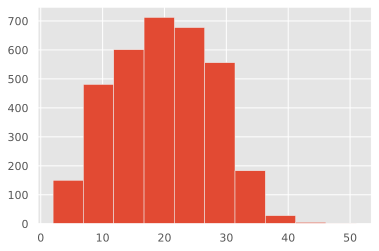

In [70]:
#Lets visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=10)
plt.savefig("/content/plots/sentence_distribution")
plt.show()

It seems most of the sentences are 10-30 words long, and the distribution is normal.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


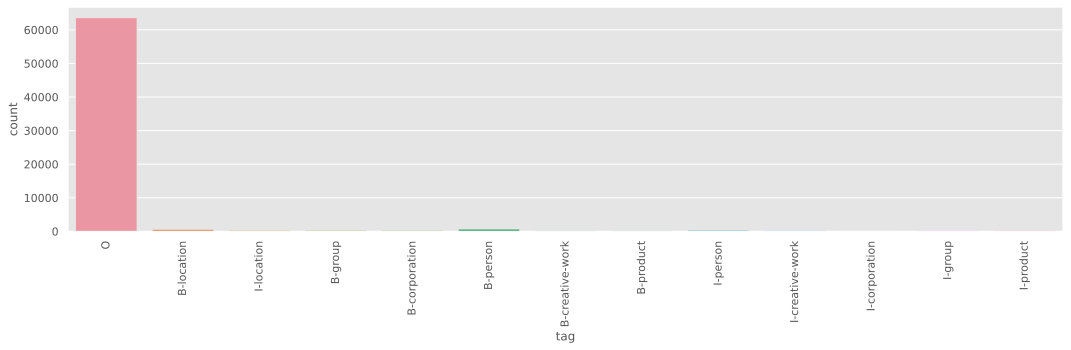

In [71]:
#Words distribution across Tags
plt.figure(figsize=(15, 5))
ax = sns.countplot('tag', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.savefig("/content/plots/word_distribution_across_tags")
plt.show()

Quite surprising, most of the words are tagged as outside of any chunk. These words can be considered as fillers and their presence might impact the classifier performance as well. Lets check the dataset again without the O tags.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


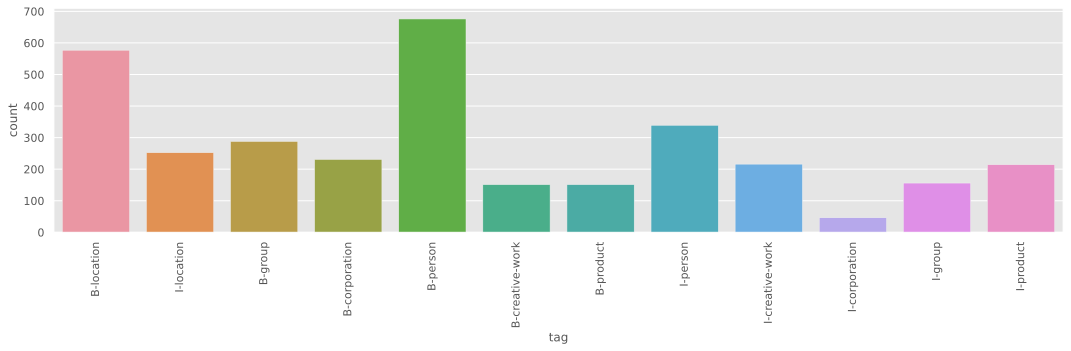

In [73]:
#Words distribution across Tags without O tag
plt.figure(figsize=(15, 5))
ax = sns.countplot('tag', data=df.loc[df['tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.savefig("/content/plots/word_distribution_wo_tag_O")
plt.show()

So our dataset mostly contains words related to geographical locations, geopolitical entities and person names.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


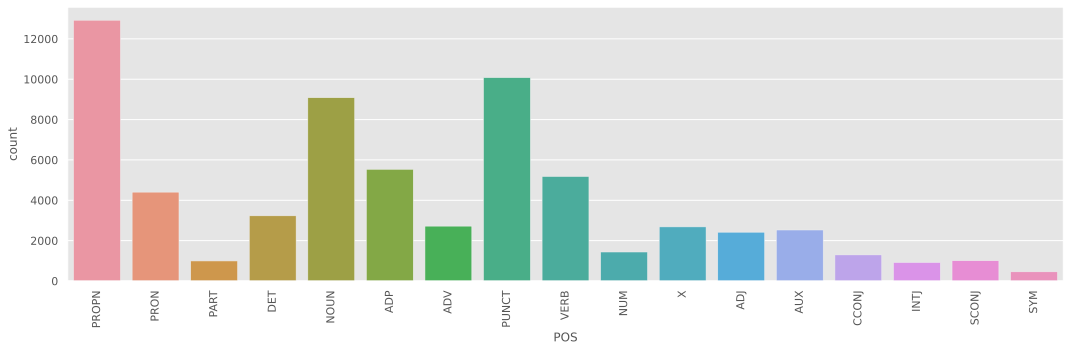

In [74]:
#Words distribution across POS
plt.figure(figsize=(15, 5))
ax = sns.countplot('POS', data=df, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.savefig("/content/plots/word_dist_across_pos")
plt.show()

# Modeling the Data

since this is a multiclass classification problem, I will start with a tree based model, Random Forest, which is among the most powerful and versatile Machine Learning Algorithms available today that can perform both classification and Regression tasks. 

Simple tree based models have been proven to provide decent performance in building NERC systems. Random Forest being one of the most popular tree based models can learn the underlying rules according to which terms are tagged. It is important that the classifier has proper features fed in to improve the performance.

I chose Random Forest because of the following reasons -
 
*   RF is able to automatically construct correlation paths from the feature space,i.e. decision rules that correspond to the translation rules that we intend to capture.
*   RF is considered one of the most accurate classifier available.


## **Performance metrics**

Before we move to the modeling part, it is important to understand the performance metrics on the basis of which the models will be evaluated. Since we are dealing with Information Extraction, we will use the following metrics to evaluate the models -
*   **Precision**
*   **Recall**
*   **F1 score**

    The metrics mentioned above are calculated using True/False positives and True/False negatives respectively.

*   **True Positives (TP)** - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.
*   **True Negatives (TN)** - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.
*   **False Positives (FP)** – When actual class is no and predicted class is yes.
*   **False Negatives (FN)** – When actual class is yes but predicted class in no.

*   **Precision** - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.

    *Precision=TP/TP+FP*
    
*   **Recall (Sensitivity)** - Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes.

    *Recall=TP/TP+FN*

*   **F1 score** - F1 Score is the weighted average of Precision and Recall.Therefore, this score takes both false positives and false negatives into account. It is the harmonic mean of the both Precision and Recall 

    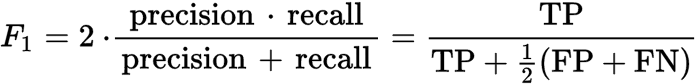









For a decent classifier, we would prefer high precision and recall values. Classification reports are used to obtain the values of these metrics in a text format per class. It is essential that the model is evaluated by these metrics per class to make sure we have a good model.

Now we shall start with the modeling part where we create new features, create the model and evaluate it on the metrics stated above.

Starting off with first model - Random Forest Classifier

**Machine Learning Approach:**

**Random Forest Classifier**

In [ ]:
# simple feature map to feed arrays into the classifier
def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word), word.isdigit(), word.isalpha()])

In [ ]:
# we divide the dataset into train and validation sets
words = [feature_map(w) for w in df['word'].values.tolist()]
tags = df['tag'].values.tolist()

In [ ]:
# lets see how the input array looks like
print(words[:5])
print(tags[:5])

[array([0, 1, 0, 9, 0, 0]), array([1, 0, 0, 2, 0, 1]), array([0, 1, 0, 2, 0, 0]), array([0, 1, 0, 3, 0, 1]), array([0, 1, 0, 4, 0, 1])]
['O', 'O', 'O', 'O', 'O']


We will use 5 fold cross validation as an input parameter to the classifier, i.e. we will divide the dataset into 5 subsets and train-test on them. Some models like decision trees and neural networks are often be able to get 100% accuracy on the training data, but perform much worse on new data. Therefore, we will train on one subset and test on the other, and repeat for every subset so that the classifier classifies correctly on average and the performance estimate is not overly optimistic.

In [ ]:
# Random Forest Classifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier

pred = cross_val_predict(RandomForestClassifier(n_estimators=500), X=words, y=tags, cv=5)

In [ ]:
# Lets check the report
from sklearn.metrics import classification_report
report = classification_report(y_pred=pred, y_true=tags)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

  B-corporation       0.32      0.03      0.06       231
B-creative-work       0.00      0.00      0.00       151
        B-group       0.00      0.00      0.00       288
     B-location       0.00      0.00      0.00       577
       B-person       0.00      0.00      0.00       676
      B-product       0.00      0.00      0.00       151
  I-corporation       0.00      0.00      0.00        46
I-creative-work       0.00      0.00      0.00       216
        I-group       0.00      0.00      0.00       156
     I-location       0.00      0.00      0.00       252
       I-person       0.00      0.00      0.00       339
      I-product       0.00      0.00      0.00       214
              O       0.95      1.00      0.97     63574

       accuracy                           0.95     66871
      macro avg       0.10      0.08      0.08     66871
   weighted avg       0.91      0.95      0.93     66871



Although we have a good average score, the model performed quite badly. The precision and recall values of almost of the classes were 0. It seems the features which require the model to take proper decisions are missing. The model is basically memorizing words and tags, which will not suffice. The context information behind each word needs to be fed to the model as well so that the predictions are more accurate.
We can either work on this model alone by improving the features or ensembling it with a more contextual model, or use a different model altogether.

I will try out a different model first. If I get same results, I will work on improving the features of the model

**Conditional Random Fields Classifier**

A Conditional Random Field (CRF) is a standard model for predicting the most likely sequence of labels that correspond to a sequence of inputs. It is a supervised learning method which has been proven to be better than the tree based models when it comes to NER. Whereas a discrete classifier predicts a label for a single sample without considering "neighboring" samples, a CRF can take context into account; e.g., the linear chain CRF (which is popular in natural language processing) predicts sequences of labels for sequences of input samples.
We will be using the LGBFS algorithm (Gradient descent using the L-BFGS method) and it works best using a limited amount of computer memory. It is a popular algorithm for parameter estimation in machine learning. Gradient Descent will be used as an optimization function.

In order to use CRF, we will enhance the feature set and create more features which can be used by the model to predict the tags correctly. Since we need to take into account the context as well, we create features which will provide consecutive POS tags for each word. Also, we add new features such as upper, lower, digit, title etc. for each word and also consider the consecutive words in the list. In short, we try to provide a sequence of features to the model for each word - the sequence containing POS tags, capitalisations, type of word(title) etc.

In [ ]:
# Feature set
def word2Features(sent, i):
    word = sent[i][0]
    pos_tag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.title(),
        'word.isdigit()': word.isdigit(),
        'pos_tag': pos_tag,
        'pos_tag': pos_tag[:2]
    } 
    if i > 0:
        word1 = sent[i-1][0]
        pos_tag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:pos_tag': pos_tag1,
            '-1:pos_tag[:2]': pos_tag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        pos_tag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:pos_tag': pos_tag1,
            '+1:pos_tag[:2]': pos_tag1[:2],
        })
    else:
        features['EOS'] = True

    return features

In [ ]:
def sent2features(sent):
    return [word2Features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, pos_tag, label in sent]

In [ ]:
#Creating the train and test set
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [ ]:
!pip install sklearn-crfsuite

     |████████████████████████████████| 747kB 4.3MB/s 


In [ ]:
# Conditional Random Field Classifier
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

In [ ]:
#We predcit using the same 5 fold cross validation
pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
#Lets evaluate the mode
from sklearn_crfsuite.metrics import flat_classification_report

report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

                 precision    recall  f1-score   support

  B-corporation       0.88      0.35      0.50       231
B-creative-work       0.42      0.13      0.20       151
        B-group       0.56      0.11      0.19       288
     B-location       0.75      0.35      0.48       577
       B-person       0.76      0.33      0.46       676
      B-product       0.92      0.16      0.27       151
  I-corporation       0.10      0.02      0.04        46
I-creative-work       0.46      0.21      0.29       216
        I-group       0.48      0.10      0.17       156
     I-location       0.71      0.28      0.40       252
       I-person       0.70      0.41      0.52       339
      I-product       0.86      0.14      0.25       214
              O       0.97      1.00      0.98     63574

       accuracy                           0.96     66871
      macro avg       0.66      0.28      0.36     66871
   weighted avg       0.95      0.96      0.95     66871



Compared to the Random Forest classifier, the CRF classifier did better as the scores have improved. However, the precision and recall metrics of the classes individually can be further improved. Maybe the model is again remembering words and not taking into the context information completely. We will try tuning the model manually to see if we can improve it.

In [ ]:
crf.fit(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [ ]:
# save the model
import joblib

joblib.dump(crf, "crf")

['crf']

**Hyperparameter optimization using Random CV search**

To improve quality try to select regularization parameters using randomized search and 3-fold cross-validation.

In [ ]:
# First we select all the tags that are relevant for us. 
# There is much more O entities in data set, but we’re more interested in other entities. 
labels = list(crf.classes_)
labels = list(filter(lambda a: a!= 'O', labels))
print(labels)

['B-location', 'I-location', 'B-group', 'B-corporation', 'B-person', 'B-creative-work', 'B-product', 'I-person', 'I-creative-work', 'I-corporation', 'I-group', 'I-product']


In [ ]:
%%time
import scipy
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

#Now we will create the Randomized CV search model wherein we will use a modified F1 scorer model considering only the relevant labels
# define fixed parameters and parameters to search
crf2 = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf2, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 28.5min finished


CPU times: user 19min 21s, sys: 6.08 s, total: 19min 27s
Wall time: 28min 41s


In [ ]:
#Lets check the best estimated parameters and CV score
print('Best parameters:', rs.best_params_)
print('Best CV score:', rs.best_score_)
print('Model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

Best parameters: {'c1': 0.06975037681169523, 'c2': 0.016000728875410937}
Best CV score: 0.3651487852478114
Model size: 0.99M


In [ ]:
#We sort the tags a bit so that they appear in an orderly fashion in the classification report
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0]))

In [ ]:
#Now we create the model again using the best estimators
crf2 = rs.best_estimator_
y_pred = crf2.predict(X)
print(metrics.flat_classification_report(
    y, y_pred, labels=sorted_labels, digits=3))

                 precision    recall  f1-score   support

  B-corporation      1.000     0.983     0.991       231
  I-corporation      1.000     0.957     0.978        46
B-creative-work      0.974     0.974     0.974       151
I-creative-work      0.982     0.991     0.986       216
        B-group      0.993     0.993     0.993       288
        I-group      0.987     1.000     0.994       156
     B-location      0.993     0.995     0.994       577
     I-location      0.996     0.992     0.994       252
       B-person      1.000     0.996     0.998       676
       I-person      1.000     0.997     0.999       339
      B-product      1.000     0.980     0.990       151
      I-product      0.995     1.000     0.998       214

      micro avg      0.995     0.992     0.993      3297
      macro avg      0.993     0.988     0.991      3297
   weighted avg      0.995     0.992     0.993      3297



This is looking absolutely beautiful. Now we have a good model with decent precision and recall scores for each class. We can fit this model and use it to predict tags given a sentence.

In [ ]:
crf2.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.06975037681169523, c2=0.016000728875410937,
    calibration_candidates=None, calibration_eta=None,
    calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [ ]:
# save the model
import joblib

joblib.dump(crf2, "finalized_crf_model.pkl")

['finalized_crf_model.pkl']

Now since we have good model, we can take sneak peek into the model and see how it is classifying and what all weights are assigned. ELI5 report has built-in support for several ML frameworks and provides a way to explain black-box models.

In [ ]:
!pip install eli5

In [ ]:
import eli5
eli5.show_weights(crf2, top=30)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


From \ To,O,B-corporation,I-corporation,B-creative-work,I-creative-work,B-group,I-group,B-location,I-location,B-person,I-person,B-product,I-product
O,2.038,0.037,-4.336,0.093,-5.923,0.345,-5.959,-0.007,-7.181,0.525,-5.219,0.087,-4.99
B-corporation,-0.833,1.192,4.253,-0.475,-1.013,-0.994,-1.834,0.0,-2.177,-1.863,-1.048,-1.272,-1.304
I-corporation,-0.794,-0.106,4.045,0.0,0.0,0.0,0.0,0.0,-1.082,-1.031,0.0,0.0,0.0
B-creative-work,-1.937,-0.115,-0.133,2.537,4.994,-0.521,-1.163,-0.785,-1.877,-1.629,-0.775,-0.123,-0.382
I-creative-work,-0.472,0.0,0.0,-0.974,5.493,-0.567,-0.638,-0.249,-1.366,0.0,-0.656,0.0,-0.001
B-group,-0.617,-1.028,-0.281,0.2,-1.088,1.283,4.104,-1.263,-2.275,-1.295,-0.833,-0.91,-1.098
I-group,-0.697,-0.255,-0.089,-0.779,-1.073,-2.672,3.769,-1.265,-2.163,-2.847,-0.773,-0.504,-0.745
B-location,-0.803,-1.509,-0.905,-0.954,-1.578,-2.129,-3.101,1.038,3.249,-2.623,-1.821,-0.884,-1.703
I-location,-0.36,-0.585,-0.444,0.0,-0.531,0.26,-1.139,-0.414,3.308,-0.988,-0.799,-0.072,-0.964
B-person,-0.327,-0.684,-0.486,0.0,-1.562,-1.133,-2.298,-1.654,-2.295,0.348,5.943,-0.869,-1.269


**Deep Learning Approach:**

**Deep Learning with Bidirectional-LSTM**

Another important strategy in building a high-performing deep learning method is understanding which type of neural network works best to tackle NER problem considering that the text is a sequential data format. yeah, you guessed it right… Long short Term Memory (LSTM). 

But not any type of LSTM, we need to use bi-directional LSTMs. I reason I am using Bi-directional LSTM is because using a standard LSTM to make predictions will only take the “past” information in a sequence of the text into account. for NER, since the context covers past and future labels in a sequence, we need to take both the past and the future information into account. 

**A bidirectional LSTM is a combination of two LSTMs — one runs forward from “right to left” and one runs backward from “left to right”.**

**Extract mappings required for the neural network**

To train a neural network, we will use two mappings as given below. The neural network will only take integers as input. So lets convert all the unique tokens in the corpus to its respective index.

*   {token} to {token id}: address the row in the embeddings matrix for the current token
*   {tag} to {tag id}: one-hot ground truth probability distribution vectors for computing the loss at the output of the network.

In [ ]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['word'].to_list()))
    else:
        vocab = list(set(data['tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(df, 'token')
tag2idx, idx2tag = get_dict_map(df, 'tag')

In [ ]:
# i will make a copy of the original dataset, so we can always revert back to it if needed
data = df.copy(deep=True)
data['word_idx'] = data['word'].map(token2idx)
data['tag_idx'] = data['tag'].map(tag2idx)

In [ ]:
data.head()

,sentence #,word,POS,tag,word_idx,tag_idx
0,1,@paulwalk,PROPN,O,12488,10
1,1,It,PRON,O,1999,10
2,1,'s,PART,O,1827,10
3,1,the,DET,O,207,10
4,1,view,NOUN,O,11947,10


In [ ]:
data_group = data.groupby(['sentence #'], as_index=False)['word', 'POS', 'tag', 'word_idx', 'tag_idx'].agg(lambda x: list(x))

data_group.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,sentence #,word,POS,tag,word_idx,tag_idx
0,1,"[@paulwalk, It, 's, the, view, from, where, I,...","[PROPN, PRON, PART, DET, NOUN, ADP, ADV, PRON,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[12488, 1999, 1827, 207, 11947, 14411, 10003, ...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1..."
1,2,"[From, Green, Newsfeed, :, AHFA, extends, dead...","[ADP, PROPN, PROPN, PUNCT, VERB, NOUN, NOUN, A...","[O, O, O, O, B-group, O, O, O, O, O, O, O, O, ...","[2596, 11919, 11801, 3793, 1853, 1126, 11289, ...","[10, 10, 10, 10, 6, 10, 10, 10, 10, 10, 10, 10..."
2,3,"[Pxleyes, Top, 50, Photography, Contest, Pictu...","[NOUN, PROPN, NUM, NOUN, PROPN, NOUN, ADP, PRO...","[B-corporation, O, O, O, O, O, O, O, O, O, O, ...","[7388, 13204, 2631, 42, 4143, 7721, 5787, 1586...","[12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1..."
3,4,"[today, is, my, last, day, at, the, office, .]","[NOUN, AUX, DET, ADJ, NOUN, ADP, DET, NOUN, PU...","[O, O, O, O, O, O, O, O, O]","[9533, 5692, 8689, 1845, 509, 14268, 207, 1080...","[10, 10, 10, 10, 10, 10, 10, 10, 10]"
4,5,"[4Dbling, 's, place, til, monday, ,, party, pa...","[ADV, PART, NOUN, PROPN, PROPN, PUNCT, PROPN, ...","[B-person, O, O, O, O, O, O, O, O, O, O, O, O, O]","[10833, 1827, 11322, 2677, 6695, 4601, 3314, 3...","[3, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10..."


**Pad sequences and split the dataset into train, test**

Padding: The LSTM layers accept sequences of same length only. Therefore we will want to transform our list of token_sequences ('Word_idx') which is lists of integers into a matrix of shape (token_sequences, max_len). We can use any length as max_len. In this project we will be using length of the longest sequence as max_len. The sequences that are shorter than max_len are padded with a specified value at the end. Import required packages

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [ ]:
def get_pad_train_test_val(data_group, data):
    n_token = len(list(set(data['word'].to_list())))
    n_tag = len(list(set(data['tag'].to_list())))
    
    tokens = data_group['word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
    
    tags = data_group['tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ntest_tags:', len(test_tags)
    )
    
    return train_tokens, test_tokens, train_tags, test_tags

train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 3054 
test_tokens length: 340 
train_tags: 3054 
test_tags: 340


**Build Model Layout**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

In [ ]:
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [ ]:
input_dim = len(list(set(data['word'].to_list())))+1
output_dim = 32
input_length = max([len(s) for s in data_group['word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  14879 
output_dim:  32 
input_length:  51 
n_tags:  13


In [ ]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 51, 32)            476128    
_________________________________________________________________
bidirectional (Bidirectional (None, 51, 64)            16640     
_________________________________________________________________
lstm_1 (LSTM)                (None, 51, 32)            12416     
_________________________________________________________________
time_distributed (TimeDistri (None, 51, 13)            429       
Total params: 505,613
Trainable params: 505,613
Non-trainable params: 0
_________________________________________________________________


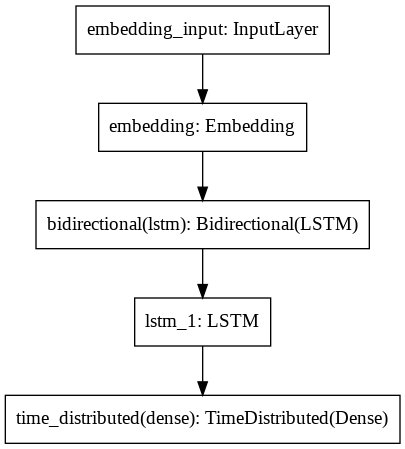

In [ ]:
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)

In [ ]:
hist = model_bilstm_lstm.fit(train_tokens, np.array(train_tags), batch_size=1000, verbose=1, epochs=10, validation_split=0.2)

Epoch 1/10
3/3 [==============================] - 11s 831ms/step - loss: nan - accuracy: 0.1477 - val_loss: 0.7648 - val_accuracy: 0.9820
Epoch 2/10
3/3 [==============================] - 2s 498ms/step - loss: 0.7467 - accuracy: 0.9743 - val_loss: 0.4683 - val_accuracy: 0.9820
Epoch 3/10
3/3 [==============================] - 2s 521ms/step - loss: 0.4913 - accuracy: 0.9806 - val_loss: 0.3765 - val_accuracy: 0.9820
Epoch 4/10
3/3 [==============================] - 1s 482ms/step - loss: 0.3797 - accuracy: 0.9808 - val_loss: 0.2833 - val_accuracy: 0.9820
Epoch 5/10
3/3 [==============================] - 1s 485ms/step - loss: 0.3070 - accuracy: 0.9807 - val_loss: 0.2703 - val_accuracy: 0.9820
Epoch 6/10
3/3 [==============================] - 1s 488ms/step - loss: 0.2953 - accuracy: 0.9809 - val_loss: 0.2656 - val_accuracy: 0.9820
Epoch 7/10
3/3 [==============================] - 1s 498ms/step - loss: 0.3017 - accuracy: 0.9803 - val_loss: 0.2714 - val_accuracy: 0.9820
Epoch 8/10
3/3 [======

In [ ]:
hist = pd.DataFrame(hist.history)

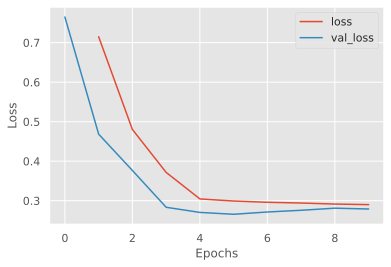

In [75]:
import matplotlib.pyplot as plt
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.legend(["loss", "val_loss"])
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.savefig("/content/plots/loss_VS_epochs")

**Performance on Test Set**

In [ ]:
results = model_bilstm_lstm.evaluate(x=test_tokens, y=np.array(test_tags))
print("test loss, test acc:", results)

11/11 [==============================] - 0s 29ms/step - loss: 0.2925 - accuracy: 0.9809
test loss, test acc: [0.29245877265930176, 0.9808534979820251]


Model started with 0.91 accuracy ended. After running 10 epochs with 1000 batch size, the final accuracy was 0.98. Which is quite amazing.

The test results are also consistent with our validation results, which is a good signal for the performance of the model

# Interpreting the results

Let's try to understand the report in brief.

CRFsuite CRF models use two kinds of features: state features and transition features.

Transition features make sense: at least model learned that **I-ENITITY** must follow **B-ENTITY**. It also learned that some transitions are unlikely, e.g. it is not common in this dataset to have a location right after an organization name, i.e. **I-corporation** -> **B-location** has a negative weight. We can expect that O -> I-ENTITY transitions to have large negative weights because they are impossible.

We can also see that **B-Corporation** -> **I-Corporation** has positive weights which makes sense, as the First names are always followed by the inner names, the same applies for organisations.

I also want to note that our dataset was actually quite small. So our CRF and Deep Learning model performed well. Their performance might not be so well if tested on the large dataset with many more Entities. In the future, if we deal with a larger dataset, and our current solution breaks down, then I have alternative ideas to make an even powerful model.


*   Using different algorithms in the CRF model. Currently it uses Gradient Descent but Stochastic Gradient Descent can be used to create a faster model.
*   One of the very recent papers (Deep contextualized word representations) introduces a new type of deep contextualized word representation that models both complex characteristics of word use (e.g., syntax and semantics), and how these uses vary across linguistic contexts (i.e., to model polysemy).

    **ELMo** has a great understanding of the language because it’s trained on a massive dataset, ELMo embeddings are trained on the 1 Billion Word Benchmark. the training is called bidirectional language model (biLM) that can learn from the past and predict the next word in a sequence of words like a sentence.


